In [100]:
import xarray as xr
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression
from scipy import stats

from functions import masked_average

save_dir = '~/DATAOUT/'
save_to = os.path.expanduser(save_dir)

In [2]:
import cartopy.crs as ccrs
import cartopy as cy
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl = ax.gridlines()#draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False


In [3]:
import matplotlib.path as mpath

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)


In [26]:
def interpretNS(stringin):
    first = stringin[:3]
    second = stringin[-3:]
    
    if first[-1] is 'N':
        low = int(first[:2])
    else: low = -1 * int(first[:2])
    if second[-1] is 'N':
        high = int(second[:2])
    else: high = -1 * int(second[:2])
    avg_lat = np.abs(np.mean([low,high]))
    weight = np.cos(np.pi/180*avg_lat)
    
    return(weight)

In [4]:
os.getcwd()

'/home/jonahks/git_repos/netcdf_analysis'

Grab CALIOP data first

In [7]:
os.chdir('/home/jonahks/drivemount/')
files = os.listdir()
files

['caliop_slfs',
 'NorESM_validation',
 'mnth15runs',
 'python-code',
 'slf_validation']

In [9]:
caliop_arc = pd.read_table('caliop_slfs/MPC_CALIOP_90N-70N.dat', sep="\s+", names=['Isotherm', 'SLF'])
caliop_arc['Isotherm']

0   -40
1   -30
2   -20
3   -10
4     0
Name: Isotherm, dtype: int64

In [65]:
all_caliop = pd.DataFrame()
weights = 0; avg = np.zeros(5);
for file in files:
    _name = file[11:-4]
    _weight = interpretNS(_name)
    _slice = pd.read_table(file, sep="\s+", names=['Isotherm', _name])
    all_caliop = pd.concat([all_caliop, _slice[_name]], axis=1, sort=False)

    # Do the averaging
    avg += _weight * _slice[_name]
    weights += _weight
all_caliop = pd.concat([all_caliop, _slice['Isotherm']], axis=1, sort=False)
all_caliop = all_caliop.set_index('Isotherm')
all_caliop['Weighted Avg'] = np.array(avg / weights)
all_caliop

,90N-70N,70S-90S,10S-30S,10N-10S,30S-50S,30N-10N,50S-70S,50N-30N,70N-50N,Weighted Avg
Isotherm,,,,,,,,,,
-40,0,0,0,0,0,0,0,0,0,0.000000
-30,6,12,6,4,7,5,9,3,5,5.578054
-20,31,39,32,26,30,28,37,21,26,28.670216
-10,55,61,64,62,60,63,70,56,56,61.357769
0,100,100,100,100,100,100,100,100,100,100.000000


In [10]:
#mnth15runs/20191122_161009_sample_param_set_wbf1_inp1
os.chdir('/home/jonahks/drivemount/mnth15runs/20191122_161009_sample_param_set_wbf1_inp1/')
files = os.listdir()
files

['20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-12.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0002-02.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-08.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-06.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-03.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-05.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0002-03.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-07.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.i.0002-01-01-00000.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-09.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-04.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-10.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0002-01.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-11.nc',
 '20191122_161009_sample_param_s

In [11]:
ds = xr.open_dataset('20191122_161009_sample_param_set_wbf1_inp1.nc')
#ds = xr.open_dataset(files[0])
gw = ds['gw']

Create new variable by dividing out the cloud fraction near each isotherm

In [12]:
ds['SLF_ISOTM'] = ds['SLFXCLD_ISOTM'] / ds['CLD_ISOTM']

In [13]:
print(ds['SLF_ISOTM'].shape) 

(15, 9, 96, 144)


Select dates after a 3 month wind-up

In [14]:
slf_isotm = ds['SLF_ISOTM'].sel(time=slice('0001-04-01', '0002-03-01'))
ds['SLF_ISOTM_AVG'] = slf_isotm.mean(dim = 'time', skipna=True)

/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [15]:
slf_isotm = ds['SLF_ISOTM_AVG']

Plot the global SLF at each isotherm

In [102]:
fig1, axes1 = plt.subplots(nrows=3,ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[20,10]);

cmin_p = np.nanmin(slf_isotm)
cmax_p = np.nanmax(slf_isotm)

cmap_p = 'bwr'
nlevels = 41
cmap2 = plt.get_cmap(cmap_p)

if cmin_p == cmax_p:
   cmax_p = cmax_p + 0.00001

levels = np.linspace(cmin_p,cmax_p,nlevels)

for data, ax in zip(slf_isotm, axes1.flatten()):
    iso = data['isotherms_mpc'].values - 273.15
    map = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr', robust=True, add_colorbar = False, levels=levels)

    ax.set_title('SLF at %s' % str(iso), fontsize=18)
    ax.coastlines()
cb_ax = fig1.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=22)
cbar.ax.set_xlabel('Supercooled Liquid Fraction', fontsize=16)

fig1.suptitle('SLF distribution across isotherms', fontsize=28)

filename = "noresm_slf_isotherms.png"
plt.savefig(save_to + filename,format = 'png', dpi = 200)
plt.clf()

<Figure size 1440x720 with 0 Axes>

In [17]:
_wgs = ds['TS'].copy()
_wgs = (_wgs * 0 + 1) * gw # copy gw into the 2d array
_wgs = _wgs / np.sum(_wgs)  # Normalize
_wgs.name = 'cell_weight'

ds['cell_weight'] = _wgs

In [18]:
mask = np.bitwise_or(ds['lat']<70, ds['lat']>90)

In [68]:
_dict = {}
glob_slf_trend = []
arc_slf_trend = []
for data in slf_isotm:
    arc_mean = masked_average(data, dim=['lat','lon'], weights=ds['cell_weight'], mask=mask)
    glob_mean = masked_average(data, dim=['lat','lon'], weights=ds['cell_weight'])
    iso = data['isotherms_mpc'].values - 273.15
    slf = arc_mean.values[0]*100
    slf2 = glob_mean.values[0]*100
    print('SLF at %s is ' % str(iso), slf)
    arc_slf_trend.append([iso, slf])
    glob_slf_trend.append([iso, slf2])
arc_slf_trend = np.transpose(arc_slf_trend)
glob_slf_trend = np.transpose(glob_slf_trend)
_dict['isotherm'] = arc_slf_trend[0]
_dict['NorESM 70N-90N'] = arc_slf_trend[1]
_dict['NorESM Global Average'] = glob_slf_trend[1]

SLF at -40.0 is  0.5616194389781489
SLF at -35.0 is  7.450646799664179
SLF at -30.0 is  8.948410228827235
SLF at -25.0 is  12.320967587077423
SLF at -20.0 is  20.70925097036171
SLF at -15.0 is  32.392769621032066
SLF at -10.0 is  46.99969184039775
SLF at -5.0 is  67.80058221313752
SLF at 0.0 is  84.65056139559708


In [69]:
df = pd.DataFrame(_dict) 
df

,isotherm,NorESM 70N-90N,NorESM Global Average
0,-40.0,0.561619,0.714611
1,-35.0,7.450647,4.394486
2,-30.0,8.948410,7.023525
3,-25.0,12.320968,10.579543
4,-20.0,20.709251,15.562775
5,-15.0,32.392770,26.998275
6,-10.0,46.999692,35.232541
7,-5.0,67.800582,53.402296
8,0.0,84.650561,86.672819


Overlap CALIOP data with NorESM output

In [72]:
spaced = []
spaced2 = []

#_caliop_isos = all_caliop['Isotherm'].values

_caliop_isos = all_caliop.index

_caliop_arc_slfs = all_caliop['90N-70N'].values
_caliop_glob_slfs = all_caliop['Weighted Avg'].values
#_caliop_isos = caliop_arc['Isotherm'].values
#_caliop_slfs = caliop_arc['SLF'].values
for i in _dict['isotherm']:
    if i in _caliop_isos:
        j = np.where(_caliop_isos == i)
        spaced.append(_caliop_arc_slfs[j][0])
        spaced2.append(_caliop_glob_slfs[j][0])
    else: 
        spaced.append(None)
        spaced2.append(None)        

In [79]:
df['CALIOP 70N-90N'] = spaced
df['CALIOP Global Average'] = spaced2
df['Arctic Error'] = df['NorESM 70N-90N'] - df['CALIOP 70N-90N']
df['Global Error'] = df['NorESM Global Average'] - df['CALIOP Global Average']

df_clean = df.dropna()
df

,isotherm,NorESM 70N-90N,NorESM Global Average,CALIOP 70N-90N,CALIOP Global Average,NorESM Error,Arctic Error,Global Error
0,-40.0,0.561619,0.714611,0.0,0.000000,0.561619,0.561619,0.714611
1,-35.0,7.450647,4.394486,NaN,NaN,NaN,NaN,NaN
2,-30.0,8.948410,7.023525,6.0,5.578054,2.948410,2.948410,1.445471
3,-25.0,12.320968,10.579543,NaN,NaN,NaN,NaN,NaN
4,-20.0,20.709251,15.562775,31.0,28.670216,-10.290749,-10.290749,-13.107442
5,-15.0,32.392770,26.998275,NaN,NaN,NaN,NaN,NaN
6,-10.0,46.999692,35.232541,55.0,61.357769,-8.000308,-8.000308,-26.125227
7,-5.0,67.800582,53.402296,NaN,NaN,NaN,NaN,NaN
8,0.0,84.650561,86.672819,100.0,100.000000,-15.349439,-15.349439,-13.327181


AttributeError: 'AxesSubplot' object has no attribute 'get_ytickmarks'

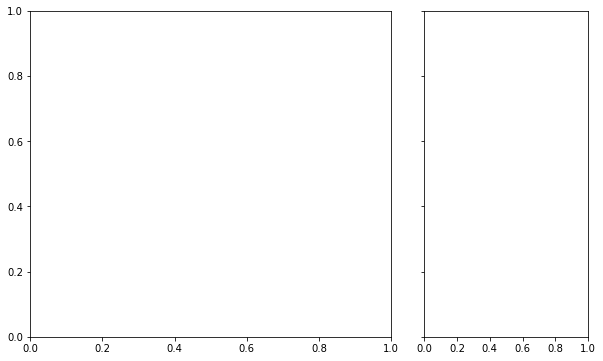

In [106]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
spec1 = GridSpec(ncols=3, nrows=1, figure=fig1)#, hspace=0.4)
f1_ax1 = fig1.add_subplot(spec1[0, :-1])
f1_ax2 = fig1.add_subplot(spec1[0, -1], sharey=f1_ax1)
axes = [f1_ax1, f1_ax2]
plt.setp(f1_ax2.get_yticklabels(), visible=False)

#fig1.gca().invert_yaxis()
f1_ax1.invert_yaxis()
f1_ax1.plot(df['NorESM 70N-90N'], df['isotherm'], label='Arctic >70N')
f1_ax1.plot(df['NorESM Global Average'], df['isotherm'], label='Global Average')
f1_ax1.scatter(df['CALIOP 70N-90N'], df['isotherm'], label='CALIOP 70N-90N', c='b')
f1_ax1.scatter(df['CALIOP Global Average'], df['isotherm'], label='CALIOP Global Avg.', c='orange')

f1_ax1.legend()
f1_ax1.set_title('Supercooled Liquid Fraction Comparison'); f1_ax1.set_ylabel('Isotherm (C)'); f1_ax1.set_xlabel('SLF (%)')

f1_ax2.invert_yaxis()
f1_ax2.scatter(df['Arctic Error'], df['isotherm'], c='b')
f1_ax2.scatter(df['Global Error'], df['isotherm'], c='orange')
f1_ax2.set_xlim((-30,10))
f1_ax2.set_title('NorESM error'); f1_ax2.set_xlabel('SLF Error (%)')

x1 = df_clean['Arctic Error']; y1 = df_clean['isotherm'];
coef = np.polyfit(x1,y1,1)
poly1d_fn = np.poly1d(coef) 
f1_ax2.plot(x1, poly1d_fn(x1), color='b')

x2 = df_clean['Global Error']; y2 = df_clean['isotherm'];
coef = np.polyfit(x2,y2,1)
poly1d_fn = np.poly1d(coef) 
f1_ax2.plot(x2, poly1d_fn(x2), color='orange')

In [103]:
filename = "slf_comparison.png"
plt.savefig(save_to + filename,format = 'png', dpi = 200)
plt.clf()

<Figure size 720x432 with 0 Axes>

In [24]:
os.chdir('/home/jonahks/drivemount/caliop_slfs/')
files = os.listdir()
files

['MPC_CALIOP_90N-70N.dat',
 'MPC_CALIOP_70S-90S.dat',
 'MPC_CALIOP_10S-30S.dat',
 'MPC_CALIOP_10N-10S.dat',
 'MPC_CALIOP_30S-50S.dat',
 'MPC_CALIOP_30N-10N.dat',
 'MPC_CALIOP_50S-70S.dat',
 'MPC_CALIOP_50N-30N.dat',
 'MPC_CALIOP_70N-50N.dat']

In [65]:
all_caliop = pd.DataFrame()
weights = 0; avg = np.zeros(5);
for file in files:
    _name = file[11:-4]
    _weight = interpretNS(_name)
    _slice = pd.read_table(file, sep="\s+", names=['Isotherm', _name])
    all_caliop = pd.concat([all_caliop, _slice[_name]], axis=1, sort=False)

    # Do the averaging
    avg += _weight * _slice[_name]
    weights += _weight
all_caliop = pd.concat([all_caliop, _slice['Isotherm']], axis=1, sort=False)
all_caliop = all_caliop.set_index('Isotherm')
all_caliop['Weighted Avg'] = np.array(avg / weights)
all_caliop

,90N-70N,70S-90S,10S-30S,10N-10S,30S-50S,30N-10N,50S-70S,50N-30N,70N-50N,Weighted Avg
Isotherm,,,,,,,,,,
-40,0,0,0,0,0,0,0,0,0,0.000000
-30,6,12,6,4,7,5,9,3,5,5.578054
-20,31,39,32,26,30,28,37,21,26,28.670216
-10,55,61,64,62,60,63,70,56,56,61.357769
0,100,100,100,100,100,100,100,100,100,100.000000


Function interprets the data name

In [55]:
all_caliop['Weighted AVG'] = np.nanmean(all_caliop, axis = 1)
all_caliop

,90-70N,10N-10S,10-30S,50-70S,50-30N,70-50N,70-90S,30-50S,30-10N,AVG
Isotherm,,,,,,,,,,
-40,0,0,0,0,0,0,0,0,0,0.000000
-30,6,4,6,9,3,5,12,7,5,6.333333
-20,31,26,32,37,21,26,39,30,28,30.000000
-10,55,62,64,70,56,56,61,60,63,60.777778
0,100,100,100,100,100,100,100,100,100,100.000000


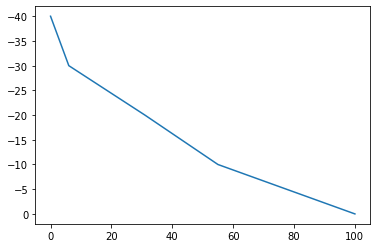

In [85]:
plt.gca().invert_yaxis()
plt.plot(caliop_arc['SLF'], caliop_arc['Isotherm'])

In [199]:
for data in slf_isotm:
    arc_mean = masked_average(data, dim=['lat','lon'], weights=ds['cell_weight'])
    iso = data['isotherms_mpc'].values - 273.15
    print('SLF at %s is ' % str(iso), arc_mean.values*100)

SLF at -40.0 is  [1.19741687]
SLF at -35.0 is  [6.37842616]
SLF at -30.0 is  [8.69901934]
SLF at -25.0 is  [13.11064629]
SLF at -20.0 is  [18.50281827]
SLF at -15.0 is  [29.34061534]
SLF at -10.0 is  [38.43012017]
SLF at -5.0 is  [54.78347867]
SLF at 0.0 is  [87.41093273]
